# 2025-11-12 Differential Equations

* Notes on integration

* Ordinary differential equations (ODE)

* Explicit methods for solving ODE

* Stability

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

# Runge-Kutta table
struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

# Helper for stablity of RK methods
function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

# Some specific RK methods
rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

# Solve an ODE with RK
function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

## Notes on integration

* Transformations can make the integrand smooth

* Transformations can make the domain shape more convenient

* Adaptive integration

* Curse of dimensionality

    * Sparse grids ([Smolyak quadrature](https://en.wikipedia.org/wiki/Sparse_grid#Smolyak%27s_quadrature_rule))
 
    * Adaptive randomized methods (Markov Chain Monte Carlo)

## High-dimensional integrals

Suppose we have a joint probability density $p \left( x; y \right)$.

Perhaps it's the probability of getting $x$ inches of snow, where $y$ represents known and unknowns quantities (location, season, wend direction El Niño year).

The marginal distribution $p \left( x \right)$ allows us to incorporate knowledge (and uncertainty) of $y$ to make a distribution over only $x$.

$$ p \left( x \right) = \int_y p \left( x; y \right) p_Y \left( y \right) $$

Curve ball: we aren't given $p \left( x; y \right)$ or $p_Y \left( y \right)$, but we can use data and models to sample these distributions.

## Ordinary Differential Equations

Given initial conditions $y_0 = y \left( t = 0 \right)$, find $y \left( t \right)$ for $t > 0$ that satisfies

$$ y' = \dot{y} = \frac{\partial y}{\partial t} = f \left( t, y \right) $$

| **Application**    | $y$                           | $f$                       |
| ------------------ | ----------------------------- | ------------------------- |
| Orbital dynamics   | position, momentum            | conservation of momentum  |
| Chemical reactions | concentraction                | conservation of atoms     |
| Epidemiology       | infected/recovered population | transmission and recovery |

$y$ can be a scalar or a vector.

### Why a causal model?

How was IHME making COVID predictions in March/April 2020?

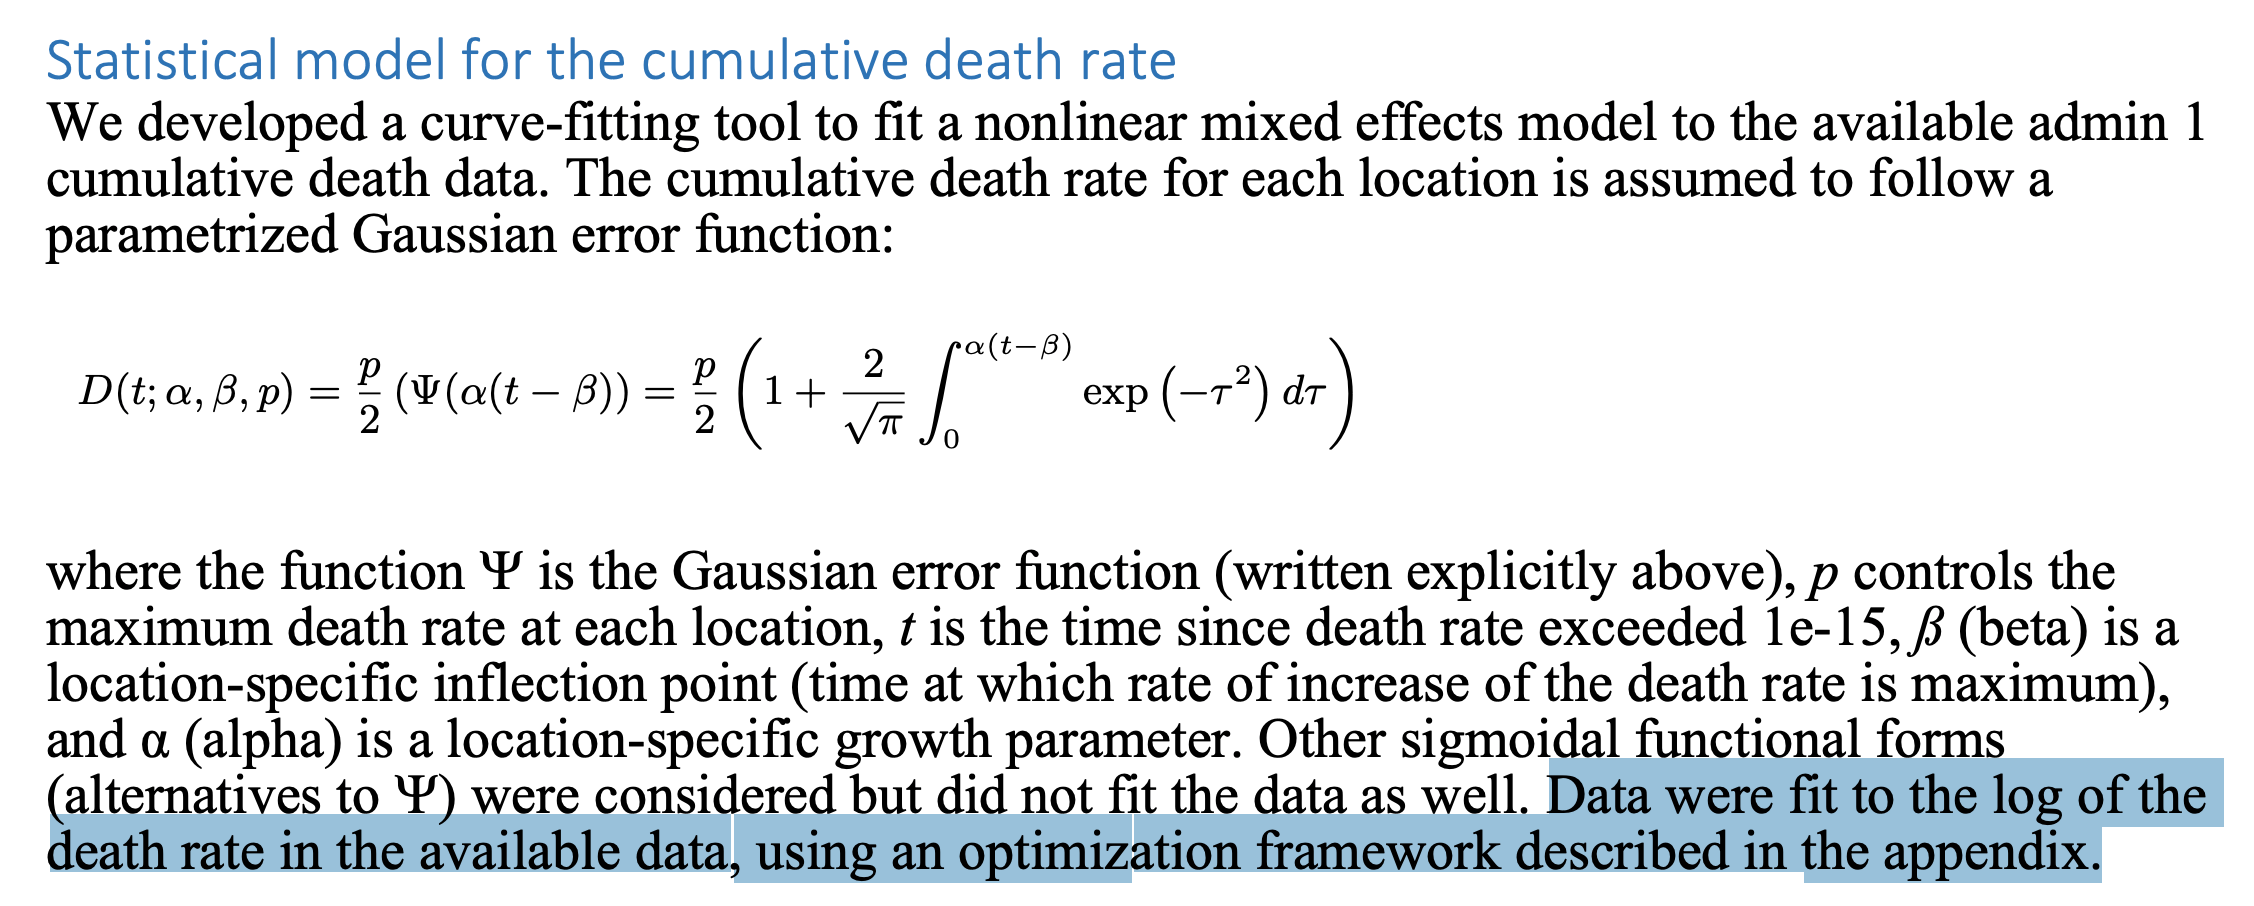
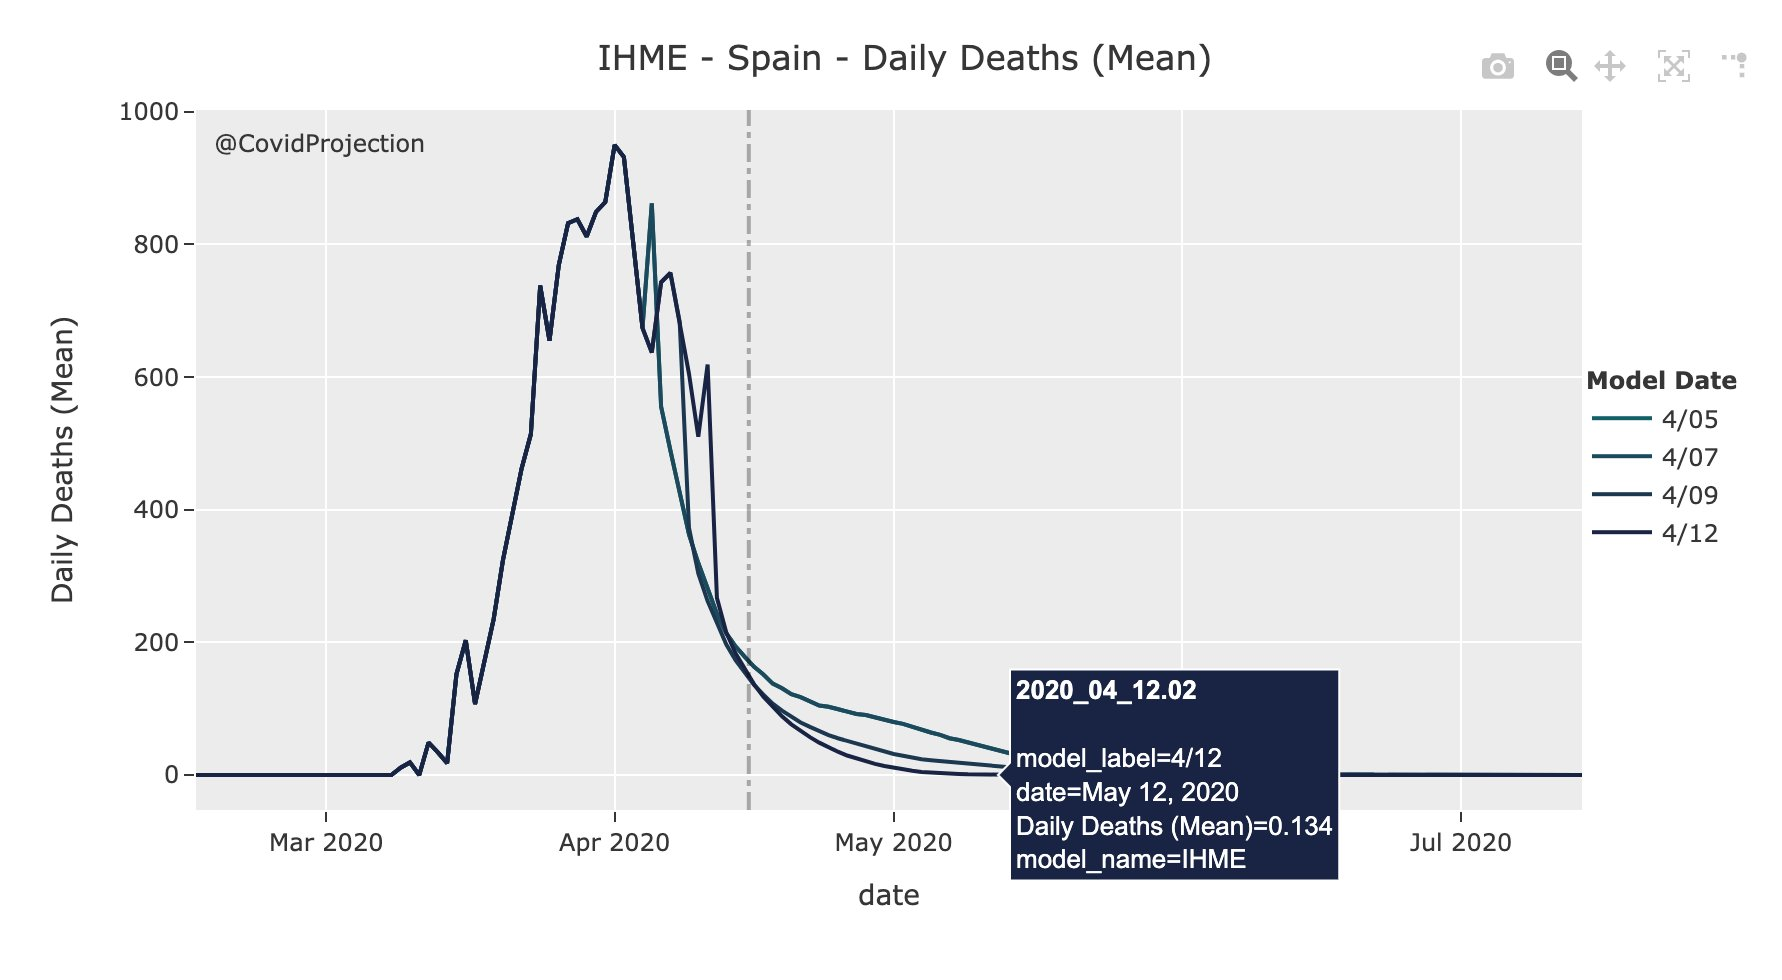

## Solving differential equations

### Linear equations

$$ y' = A \left( t \right) y + \text{source} \left( t \right) $$

Autonomous if $A \left( t \right) = A$ and the source term is independent of $t$.

If $y$ and $a = A$ are scalars, then $y \left( t \right) = e^{a t} y_0$.

If $y$ is a vector and $A$ is a matrix, then we have a similar solution for systems: $y \left( t \right) = e^{A t} y_0$.

### Matrix exponentation

What does it mean to exponentiate a matrix?
To the Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \cdots $$

There exist many [practical ways to compute it](https://bpb-us-e1.wpmucdn.com/blogs.cornell.edu/dist/c/9924/files/2021/10/19ways.pdf).

Exploration:
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists.
Derive a finite expression for the matrix exponential using the scalar `exp` function.

## Forward Euler Method

The simplest method for solving $y' \left( t \right) = f \left( t, y \right)$ is to use a finite difference to write

$$ y' \approx \frac{y \left( h \right) - y \left( 0 \right)}{h} $$

which yields the solution estimate

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( 0, y \left( 0 \right) \right) $$

where $h$ is the step size.
Let's try this on a scalar problem

$$ y' = - k \left( y - \cos \left( t \right) \right) $$

where $k$ is a parameter controlling the rate at which the solution $u \left( t \right)$ is pulled toward the curve $\cos \left( t \right)$.

In [2]:
# Forward Euler ODE solver
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

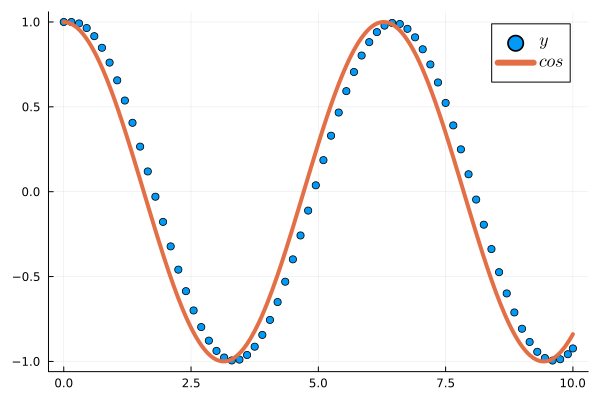

In [3]:
f1(t, y; k=5) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=10, h=.15)
scatter(thist, yhist[1, :], label="\$y\$")
plot!(cos, label="\$cos\$")

### Forward Euler for systems

Consider the linear system

$$ \begin{split}
  \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}' =
  \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}
  \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}
\end{split} $$

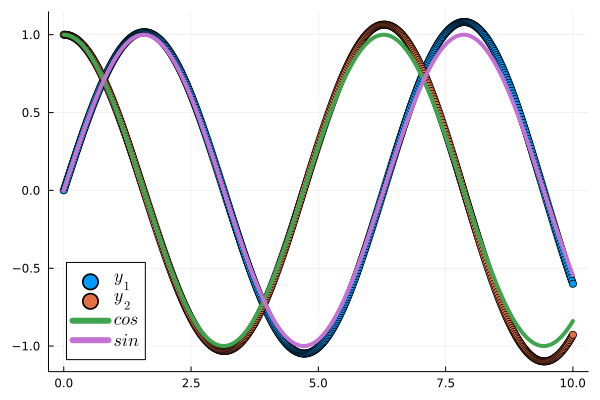

In [4]:
f2(t, y) = [0 1; -1 0] * y

thist, yhist = ode_euler(f2, [0., 1], h=.02, tfinal=10)
scatter(thist, yhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

In [5]:
# The eigevalues tell us why Euler struggles (below)
eigen([0 1; -1 0])

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Matrix{ComplexF64}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

## Runge-Kutta 4

We won't dive into the math here, but the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) can be thought of as a weighted average of multiple finite differencing schemes.

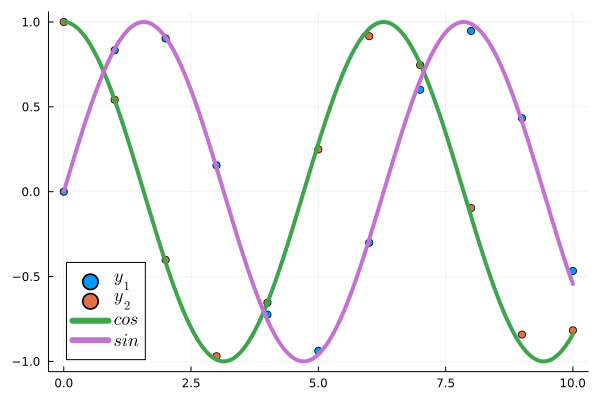

In [6]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=1, tfinal=10)
scatter(thist, yhist', label=["\$y_1\$" "\$y_2\$"])
plot!([cos, sin], label=["\$cos\$" "\$sin\$"])

Runge-Kutta 4 appears to integrate this system with much large time steps.
This method evaluates $f \left( y \right)$ four times per step so the cost is about equal when the step size $h$ is 4x larger than for forward Euler.

## Linear stability analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem

$$ y' = \lambda y $$

for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps

$$ y \rightarrow y + h \lambda y = \underbrace{(1 + h \lambda)}_{R \left( h \lambda \right)} y $$

When does this map cause solutions to "blow up" and when is it stable?

In [7]:
function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    contour!(x, y, (x, y) -> abs(Rz(x + 1im*y)), color=:black, linewidth=2, levels=[1.])
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 1 method)

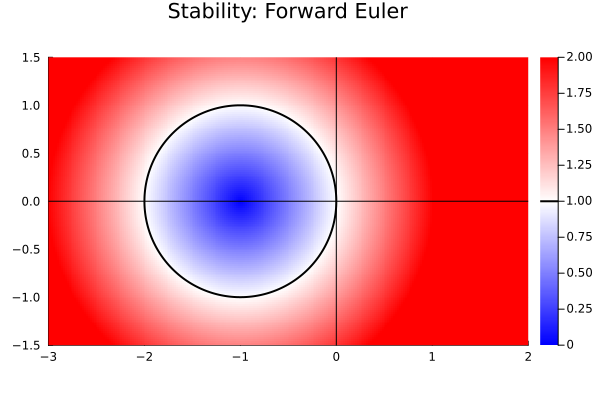

In [8]:
plot_stability(z -> 1 + z, "Forward Euler")

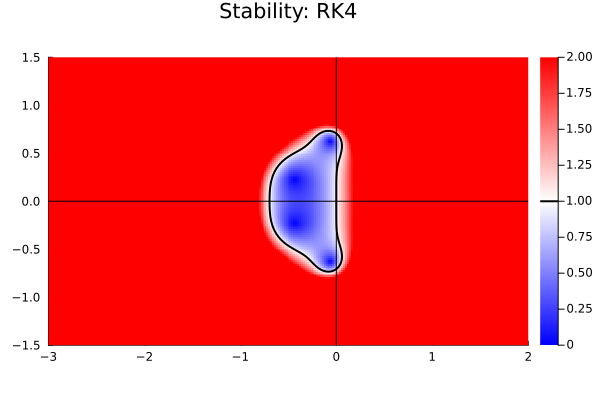

In [9]:
plot_stability(z -> rk_stability(4z, rk4), "RK4")

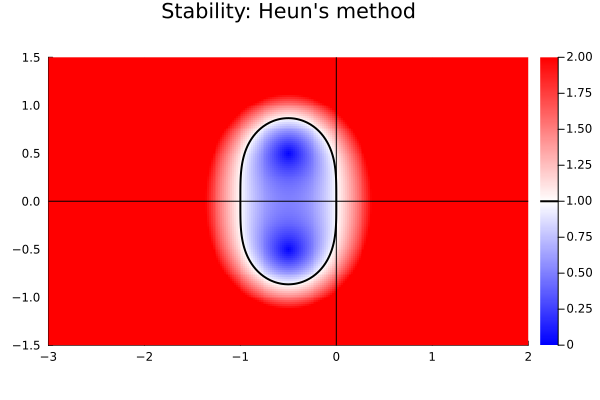

In [10]:
plot_stability(z -> rk_stability(2z, heun), "Heun's method")

## Implicit methods

Recall that forward Euler is the step

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( 0, y \left( 0 \right) \right) $$

This can be evaluated explicitly; all the terms on the right hand side are known so the approximation $\tilde{y} \left( h \right)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, backward Euler (or "implicit Euler"),

$$ \tilde{y} \left( h \right) =  y \left( 0 \right) + h f \left( h, \tilde{y} \left( h \right) \right) $$

This is a (generally) nonlinear equation for $\tilde{y} \left( h \right)$.
For the test equation $y' = \lambda y$, the backward Euler method is

$$ \tilde{y} \left( h \right) + h \lambda \tilde{y} \left( h \right) $$

or

$$ \tilde y \left( h \right) = \underbrace{\frac{1}{1 - h \lambda}}_{R \left( h\lambda \right)} y(0) $$

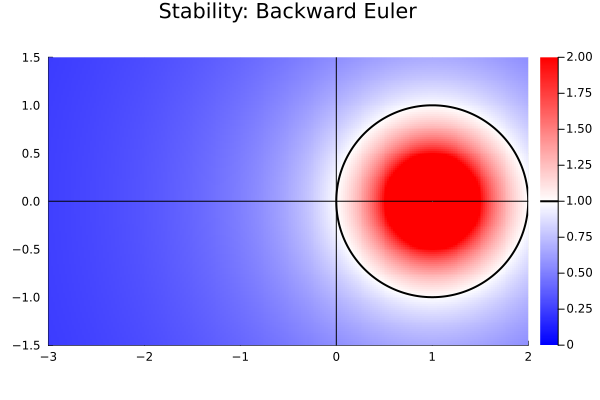

In [11]:
plot_stability(z -> 1/(1-z), "Backward Euler")

## Using implicit methods

$$ \tilde{y} \left( h \right) = y \left( 0 \right) + h f \left( \tilde{y} \left( h \right) \right) $$

We have a linear solve for the linear problem and a non-linear (often Newton) solve for the non-linear problem.
We need the Jacobian or finite differencing.

In [12]:
using LinearAlgebra

# Backward Euler ODE solver
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        ynext = y + h * f(t, y)
        i = 1
        while norm(ynext - (y + h * f(t, ynext))) > 1e-10
            i += 1
            ynext = y + h * f(t, ynext)
        end
        y = ynext
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

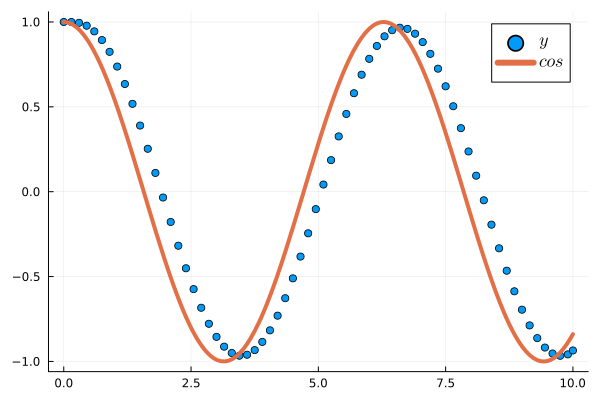

In [13]:
f1(t, y; k=5) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=10, h=.15)
scatter(thist, yhist[1, :], label="\$y\$")
plot!(cos, label="\$cos\$")

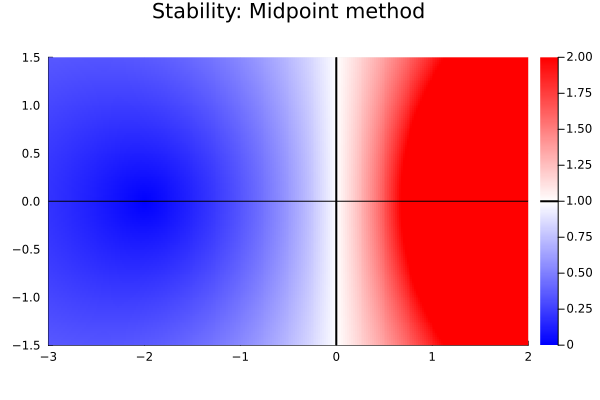

In [14]:
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")